In [ ]:
#Written by z5222191 for COMP9517 Assignment 2

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [3]:
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
train_positive = []
#Reading all the images from train_positive_A
for i in range(8):
    path_name = 'train/train_positive_A/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [5]:
#Reading all the images from train_positive_B
for i in range(7):
    path_name = 'train/train_positive_B/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [6]:
#Reading all the images from train_positive_C
for i in range(8):
    path_name = 'train/train_positive_C/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_positive.append(img)

In [7]:
len(train_positive)

22114

In [8]:
#Similarly we create a list called train_negative
train_negative = []
for i in range(10):
    path_name = 'train/train_negative_A/0000000' + str(i)
    #print(path_name)
    entries = Path(path_name)
    for entry in sorted(entries.iterdir()):
        img = cv2.imread(str(entry))
        train_negative.append(img)

In [9]:
len(train_negative)

10000

In [10]:
#Getting equal slices of positive and negative trainig data
positive_batch = train_positive[:5000]
negative_batch = train_negative[:5000]

In [11]:
positive_labels = [1] * 5000
negative_labels = [0] * 5000

In [12]:
image_shape = positive_batch[0].shape
image_shape

(80, 64, 3)

In [13]:
#Flattening images to store in dataframe
for i in range(5000):
    positive_batch[i] = positive_batch[i].flatten()
    negative_batch[i] = negative_batch[i].flatten()

In [14]:
positive = pd.DataFrame(list(zip(positive_batch, positive_labels)), columns =['Image', 'Label']) 

In [15]:
negative = pd.DataFrame(list(zip(negative_batch, negative_labels)), columns =['Image', 'Label']) 

In [16]:
#Data is the basic dataframe created with labels of positive and negative labels
data = pd.concat([positive, negative], ignore_index=True)

In [17]:
data

,Image,Label
0,"[85, 126, 102, 138, 156, 132, 41, 67, 40, 84, ...",1
1,"[45, 43, 43, 50, 43, 42, 50, 46, 41, 48, 46, 4...",1
2,"[13, 13, 46, 20, 20, 28, 44, 44, 48, 85, 87, 9...",1
3,"[249, 245, 241, 255, 251, 248, 244, 240, 243, ...",1
4,"[31, 38, 22, 31, 32, 20, 30, 33, 24, 29, 33, 2...",1
...,...,...
9995,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0
9996,"[159, 163, 164, 169, 168, 175, 178, 156, 165, ...",0
9997,"[168, 160, 143, 159, 148, 135, 157, 145, 136, ...",0
9998,"[225, 216, 202, 225, 216, 202, 225, 216, 202, ...",0


In [18]:
hog_features = []
for i in range(len(data['Image'])):
    temp = data['Image'][i]
    #print(temp.shape)
    temp = temp.reshape(80,64,3)
    #print(temp.shape)
    #orientations - 9 and search by 8x8 blocks
    feature_matrix, hog_image = hog(temp, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    #plt.imshow(hog_image)
    hog_features.append(feature_matrix)

In [19]:
print(len(hog_features))
print(hog_features[0].shape)

10000
(2268,)


In [20]:
#extract orb features and store in list
orb_features = []
for i in range(len(data['Image'])):
    temp = data['Image'][i]
    #print(temp.shape)
    temp = temp.reshape(80,64,3)
    #print(temp.size)
    #print(temp.shape)
    orb = cv2.ORB_create()
    key_points,descriptors = orb.detectAndCompute(temp,None)
    #print(descriptors)
    #print(descriptors.shape)
    if descriptors is not None:
        #flatten the array
        descriptors = descriptors.flatten()
        #print(descriptors.shape)
        #check if descriptor array is of minimum size else pad with 0
        minimum_size = temp.size//10
        if descriptors.size < minimum_size:
            descriptors = np.concatenate([descriptors, np.zeros(minimum_size - descriptors.size)])
    else:
        descriptors = np.zeros(minimum_size)
    #print(descriptors.shape)
    orb_features.append(descriptors)

In [21]:
print(len(orb_features))
print(orb_features[0].shape)

10000
(1536,)


In [22]:
kaze_features = []
for i in range(len(data['Image'])):
    temp = data['Image'][i]
    #print(temp.shape)
    temp = temp.reshape(80,64,3)
    #print(temp.size)
    #print(temp.shape)
    kaze = cv2.KAZE_create()
    key_points,descriptors = kaze.detectAndCompute(temp,None)
    #print(descriptors)
    #print(descriptors.shape)
    if descriptors is not None:
        descriptors = descriptors.flatten()
        #print(descriptors.shape)
        minimum_size = temp.size//10
        #check if descriptor array is of minimum size else pad with 0
        if descriptors.size < minimum_size:
            descriptors = np.concatenate([descriptors, np.zeros(minimum_size - descriptors.size)])
        elif descriptors.size > minimum_size:
            descriptors = descriptors[:minimum_size]
    else:
        descriptors = np.zeros(minimum_size)
    #print(descriptors.shape)
    kaze_features.append(descriptors)

In [23]:
print(len(kaze_features))
print(kaze_features[0].shape)

10000
(1536,)


In [24]:
#Add the features to the dataframe to their respective images and labels
data['hog_features'] = hog_features
data['orb_features'] = orb_features
data['kaze_features'] = kaze_features

In [25]:
data

,Image,Label,hog_features,orb_features,kaze_features
0,"[85, 126, 102, 138, 156, 132, 41, 67, 40, 84, ...",1,"[0.26322898426171276, 0.06297035253461403, 0.0...","[116.0, 167.0, 248.0, 230.0, 170.0, 105.0, 87....","[0.029554084, -0.016833646, 0.038285006, 0.046..."
1,"[45, 43, 43, 50, 43, 42, 50, 46, 41, 48, 46, 4...",1,"[0.35834813063792037, 0.3557791162945998, 0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01644514873623848, -0.011588056571781635, ..."
2,"[13, 13, 46, 20, 20, 28, 44, 44, 48, 85, 87, 9...",1,"[0.24073522742786724, 0.3309773255937661, 0.08...","[11.0, 95.0, 98.0, 154.0, 243.0, 180.0, 190.0,...","[-0.116363406, -0.058786247, 0.13851662, 0.090..."
3,"[249, 245, 241, 255, 251, 248, 244, 240, 243, ...",1,"[0.2327839870331554, 0.2053042475619035, 0.232...","[62.0, 240.0, 104.0, 75.0, 189.0, 212.0, 219.0...","[0.0012870148, 0.0062659215, 0.004209111, 0.00..."
4,"[31, 38, 22, 31, 32, 20, 30, 33, 24, 29, 33, 2...",1,"[0.2741637707346994, 0.03282843590448066, 0.23...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.16166079, 0.10935857, 0.20557232, 0.116168..."
...,...,...,...,...,...
9995,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[159, 163, 164, 169, 168, 175, 178, 156, 165, ...",0,"[0.1410433031960831, 0.23377168500470988, 0.26...","[13.0, 148.0, 77.0, 169.0, 176.0, 46.0, 106.0,...","[-0.08075611, -0.17570443, 0.08633931, 0.18146..."
9997,"[168, 160, 143, 159, 148, 135, 157, 145, 136, ...",0,"[0.24411617911820588, 0.07405114817817911, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[225, 216, 202, 225, 216, 202, 225, 216, 202, ...",0,"[0.06343854330603586, 0.03319965930645292, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
#Converting and saving the dataframe as a csv file
#data.to_csv("Features1.csv")

In [27]:
#shuffle data frame before classification to prevent bias
data = shuffle(data)

In [28]:
data

,Image,Label,hog_features,orb_features,kaze_features
9206,"[226, 178, 106, 227, 178, 107, 227, 177, 107, ...",0,"[0.1771665978082208, 0.10873661638313599, 0.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4555,"[99, 127, 184, 62, 68, 98, 46, 45, 56, 55, 53,...",1,"[0.28389708764304095, 0.22820839236945928, 0.2...","[186.0, 82.0, 238.0, 247.0, 102.0, 18.0, 189.0...","[-0.11403386, -0.33580017, 0.11403386, 0.33580..."
7726,"[10, 12, 12, 9, 10, 12, 6, 8, 11, 8, 9, 13, 14...",0,"[0.1857613649147087, 0.0835521147493242, 0.012...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2448,"[20, 37, 45, 20, 37, 46, 20, 37, 45, 20, 38, 4...",1,"[0.1109899882176166, 0.0, 0.07199579176041762,...","[9.0, 147.0, 188.0, 175.0, 48.0, 159.0, 112.0,...","[-0.0662649, 0.011761363, 0.102560766, 0.04712..."
4399,"[87, 78, 65, 96, 85, 73, 105, 91, 78, 107, 94,...",1,"[0.24468060811026307, 0.04589106794627006, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07334889, -0.031139899, 0.108350836, 0.1245..."
...,...,...,...,...,...
7626,"[66, 75, 51, 70, 78, 57, 70, 82, 56, 67, 83, 5...",0,"[0.15567028875356406, 0.11159588349931568, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.742529563372955e-05, 0.01990165002644062, 0..."
5972,"[160, 145, 119, 161, 143, 118, 164, 144, 119, ...",0,"[0.24465463902600854, 0.11567697485513988, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5122,"[19, 20, 18, 17, 17, 16, 21, 21, 21, 21, 21, 2...",0,"[0.24134737707729537, 0.07661885508886163, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0003193434386048466, 0.0018177557503804564..."
38,"[113, 163, 181, 0, 20, 45, 23, 41, 74, 35, 40,...",1,"[0.3577377811975908, 0.0, 0.0, 0.0, 0.10136262...","[221.0, 76.0, 87.0, 229.0, 66.0, 78.0, 110.0, ...","[0.0046349596, -0.008789492, 0.009124, 0.01381..."


In [29]:
# data['orb_features'][0].shape

In [30]:
# x = np.array(data['orb_features'])
# y = np.array(data['Label'])

In [31]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)

In [32]:
# temp = []
# for i in range(len(x_train)):
#     for x in x_train[i]:
#         temp.append(x)

In [33]:
# len(temp)

In [34]:
# x_train = np.array(temp).reshape(1500,1536)

In [35]:
# x_train.shape

In [36]:
# temp = []
# for i in range(len(x_test)):
#     for x in x_test[i]:
#         temp.append(x)

In [37]:
# x_test = np.array(temp).reshape(500,1536)

In [38]:
# x_test.shape

In [39]:
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(x_train,y_train)
# knn_y_predict=model.predict(x_test)
# # accuracy score - KNN
# knn_accuracy_score=metrics.accuracy_score(y_test, knn_y_predict)
# # recall score - KNN
# knn_recall_score=metrics.recall_score(y_test, knn_y_predict, average='macro')
# print(f'KNN Accuracy:{knn_accuracy_score:0.3f}  KNN Recall: {knn_recall_score:0.3f}.\n')

In [40]:
# x = np.array(data['kaze_features'])
# y = np.array(data['Label'])
# x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)

In [41]:
# temp = []
# for i in range(len(x_train)):
#     for x in x_train[i]:
#         temp.append(x)

In [42]:
# x_train = np.array(temp).reshape(1500,1536)

In [43]:
# temp = []
# for i in range(len(x_test)):
#     for x in x_test[i]:
#         temp.append(x)

In [44]:
# x_test = np.array(temp).reshape(500,1536)

In [45]:
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(x_train,y_train)
# knn_y_predict=model.predict(x_test)
# # accuracy score - KNN
# knn_accuracy_score=metrics.accuracy_score(y_test, knn_y_predict)
# # recall score - KNN
# knn_recall_score=metrics.recall_score(y_test, knn_y_predict, average='macro')
# print(f'KNN Accuracy:{knn_accuracy_score:0.3f}  KNN Recall: {knn_recall_score:0.3f}.\n')

In [62]:
#The features of each image are processed using KNN and the AUC values are stored for visualisation later
KNN_Scores = []
features = ['orb_features','kaze_features','hog_features']
for feature in features:
    x = np.array(data[feature])
    y = np.array(data['Label'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)
    x_train_len = len(x_train)
    x_train_shape = len(x_train[0])
    x_test_len = len(x_test)
    x_test_shape = len(x_test[0])
    #print(x_train_shape,x_train_len)
    temp1 = []
    for i in range(len(x_train)):
        for x in x_train[i]:
            temp1.append(x)
    x_train = np.array(temp1).reshape(x_train_len,x_train_shape)
    temp2 = []
    for i in range(len(x_test)):
        for x in x_test[i]:
            temp2.append(x)
    x_test = np.array(temp2).reshape(x_test_len,x_test_shape)
    #define the classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    #svc = SVC(kernel='rbf', gamma=0.00001, C=1000,probability=True)
    #train the data
    knn.fit(x_train, y_train)
    #predict test
    knn_predict = knn.predict(x_test)
    #calculate accuracy and metrics
    knn_accuracy_score = metrics.accuracy_score(y_test,knn_predict)
    knn_recall_score=metrics.recall_score(y_test, knn_predict, average='macro')
    confusion_matrix=metrics.confusion_matrix(y_test, svc_predict)
    average_precision = metrics.average_precision_score(y_test, knn_predict)
    print(f'KNN Accuracy for {feature} : {knn_accuracy_score:0.3f}\n')
    print(f'KNN Recall for {feature} : {knn_recall_score:0.3f}\n')
    print(f'KNN Precision for {feature} : {average_precision:0.3f}\n')
    print(f'Confusion Matrix\n')
    #confusion matric and AUC score calculation
    print(confusion_matrix)
    fp_rate, tp_rate, thresholds = roc_curve(y_test, knn_predict)
    KNN_Scores.append((fp_rate,tp_rate,auc(fp_rate, tp_rate)))
    print('\n')

KNN Accuracy for orb_features : 0.613

KNN Recall for orb_features : 0.614

KNN Precision for orb_features : 0.580

Confusion Matrix

[[1210   31]
 [  32 1227]]


KNN Accuracy for kaze_features : 0.698

KNN Recall for kaze_features : 0.700

KNN Precision for kaze_features : 0.687

Confusion Matrix

[[1210   31]
 [  32 1227]]


KNN Accuracy for hog_features : 0.756

KNN Recall for hog_features : 0.758

KNN Precision for hog_features : 0.759

Confusion Matrix

[[1210   31]
 [  32 1227]]




In [65]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
SVC_Scores = []
features = ['orb_features','kaze_features','hog_features']
for feature in features:
    x = np.array(data[feature])
    y = np.array(data['Label'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=6)
    x_train_len = len(x_train)
    x_train_shape = len(x_train[0])
    x_test_len = len(x_test)
    x_test_shape = len(x_test[0])
    #print(x_train_shape,x_train_len)
    temp1 = []
    for i in range(len(x_train)):
        for x in x_train[i]:
            temp1.append(x)
    x_train = np.array(temp1).reshape(x_train_len,x_train_shape)
    temp2 = []
    for i in range(len(x_test)):
        for x in x_test[i]:
            temp2.append(x)
    x_test = np.array(temp2).reshape(x_test_len,x_test_shape)
    svc = LinearSVC(dual=False)
    #svc = SVC(kernel='rbf', gamma=0.00001, C=1000,probability=True)
    svc.fit(x_train, y_train)
    svc_predict = svc.predict(x_test)
    svc_accuracy_score = metrics.accuracy_score(y_test,svc_predict)
    svc_recall_score=metrics.recall_score(y_test, svc_predict, average='macro')
    confusion_matrix=metrics.confusion_matrix(y_test, svc_predict)
    average_precision = metrics.average_precision_score(y_test, svc_predict)
    #test.append(metrics.roc_auc_score(y_test, svc.predict(x_test)))
    print(f'SVC Accuracy for {feature} : {svc_accuracy_score:0.3f}\n')
    print(f'SVC Recall for {feature} : {svc_recall_score:0.3f}\n')
    print(f'SVC Precision for {feature} : {average_precision:0.3f}\n')
    print(f'Confusion Matrix\n')
    print(confusion_matrix)
    fp_rate, tp_rate, thresholds = roc_curve(y_test, svc_predict)
    SVC_Scores.append((fp_rate,tp_rate,auc(fp_rate, tp_rate)))
    print('\n')

SVC Accuracy for orb_features : 0.611

SVC Recall for orb_features : 0.612

SVC Precision for orb_features : 0.577

Confusion Matrix

[[949 292]
 [681 578]]


SVC Accuracy for kaze_features : 0.842

SVC Recall for kaze_features : 0.842

SVC Precision for kaze_features : 0.792

Confusion Matrix

[[1053  188]
 [ 207 1052]]


SVC Accuracy for hog_features : 0.975

SVC Recall for hog_features : 0.975

SVC Precision for hog_features : 0.963

Confusion Matrix

[[1210   31]
 [  32 1227]]




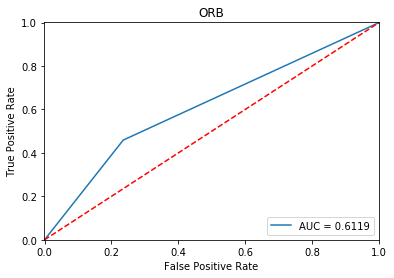

In [56]:
plt.title('ORB')
plt.plot(SVC_Scores[0][0], SVC_Scores[0][1], label='AUC = %0.4f'% SVC_Scores[0][2])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

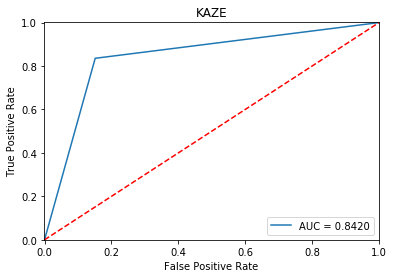

In [57]:
plt.title('KAZE')
plt.plot(SVC_Scores[1][0], SVC_Scores[1][1], label='AUC = %0.4f'% SVC_Scores[1][2])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

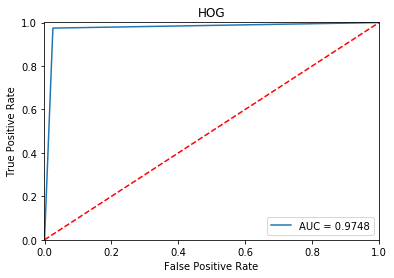

In [58]:
plt.title('HOG')
plt.plot(SVC_Scores[2][0], SVC_Scores[2][1], label='AUC = %0.4f'% SVC_Scores[2][2])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

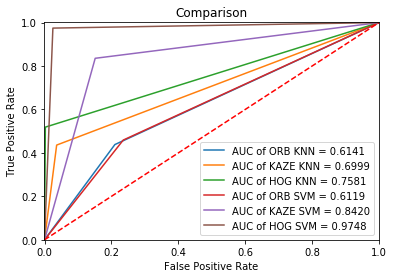

In [66]:
plt.title('Comparison')
plt.plot(KNN_Scores[0][0], KNN_Scores[0][1], label='AUC of ORB KNN = %0.4f'% KNN_Scores[0][2])
plt.plot(KNN_Scores[1][0], KNN_Scores[1][1], label='AUC of KAZE KNN = %0.4f'% KNN_Scores[1][2])
plt.plot(KNN_Scores[2][0], KNN_Scores[2][1], label='AUC of HOG KNN = %0.4f'% KNN_Scores[2][2])
plt.plot(SVC_Scores[0][0], SVC_Scores[0][1], label='AUC of ORB SVM = %0.4f'% SVC_Scores[0][2])
plt.plot(SVC_Scores[1][0], SVC_Scores[1][1], label='AUC of KAZE SVM = %0.4f'% SVC_Scores[1][2])
plt.plot(SVC_Scores[2][0], SVC_Scores[2][1], label='AUC of HOG SVM = %0.4f'% SVC_Scores[2][2])
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()